Processing single image...
ROI polygon vertices (in pixel coordinates):
  Vertex 1: (x=192, y=448)
  Vertex 2: (x=460, y=448)
  Vertex 3: (x=460, y=64)
  Vertex 4: (x=192, y=64)
Right lane base detected at x = 355, (y = 460)
Window 1: Center at (x=360, y=437), found 563 pixels
Window 2: Center at (x=332, y=391), found 811 pixels
Window 3: Center at (x=298, y=345), found 843 pixels
Window 4: Center at (x=261, y=299), found 563 pixels
Window 5: Center at (x=219, y=253), found 320 pixels
Window 6: Center at (x=219, y=207), found 0 pixels
Window 7: Center at (x=219, y=161), found 0 pixels
Window 8: Center at (x=219, y=115), found 0 pixels
Window 9: Center at (x=219, y=69), found 0 pixels
Window 10: Center at (x=219, y=23), found 0 pixels
ROI polygon vertices (in pixel coordinates):
  Vertex 1: (x=0, y=448)
  Vertex 2: (x=640, y=448)
  Vertex 3: (x=640, y=64)
  Vertex 4: (x=0, y=64)


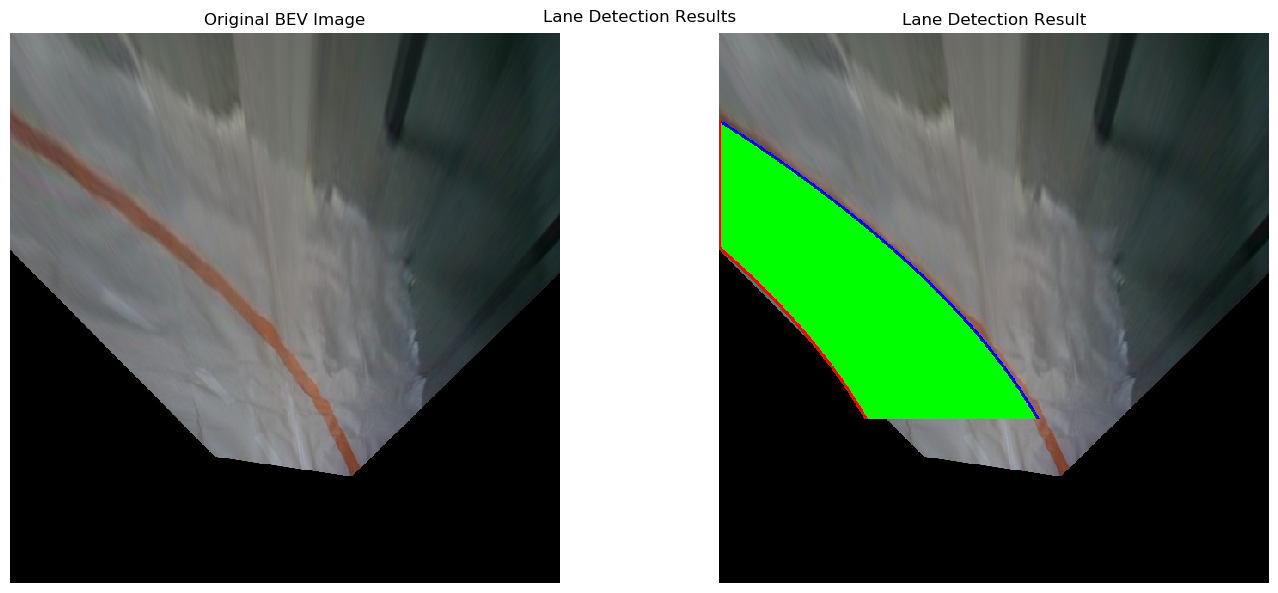

Processing video...
Input video properties:
  Resolution: 640x640
  FPS: 30
  Total frames: 492
Processing video frames...
Progress: 30/492 frames (6.1%)
Progress: 60/492 frames (12.2%)
Progress: 90/492 frames (18.3%)


/tmp/ipykernel_1957621/3433949192.py:304: RankWarning: Polyfit may be poorly conditioned
  right_fit = self.fit_polynomial(rightx, righty, bev.shape)


Progress: 120/492 frames (24.4%)
Progress: 150/492 frames (30.5%)
Progress: 180/492 frames (36.6%)
Progress: 210/492 frames (42.7%)
Progress: 240/492 frames (48.8%)
Progress: 270/492 frames (54.9%)
Progress: 300/492 frames (61.0%)
Progress: 330/492 frames (67.1%)
Progress: 360/492 frames (73.2%)


/tmp/ipykernel_1957621/3433949192.py:304: RankWarning: Polyfit may be poorly conditioned
  right_fit = self.fit_polynomial(rightx, righty, bev.shape)
/tmp/ipykernel_1957621/3433949192.py:304: RankWarning: Polyfit may be poorly conditioned
  right_fit = self.fit_polynomial(rightx, righty, bev.shape)
/tmp/ipykernel_1957621/3433949192.py:304: RankWarning: Polyfit may be poorly conditioned
  right_fit = self.fit_polynomial(rightx, righty, bev.shape)
/tmp/ipykernel_1957621/3433949192.py:304: RankWarning: Polyfit may be poorly conditioned
  right_fit = self.fit_polynomial(rightx, righty, bev.shape)


Progress: 390/492 frames (79.3%)
Progress: 420/492 frames (85.4%)
Progress: 450/492 frames (91.5%)
Progress: 480/492 frames (97.6%)
Video processing completed!
  Processed frames: 492/492
  Output saved to: output_lane_detection.mp4
Video processing completed! Output saved as: output_lane_detection.mp4


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Optional
import os

class LaneDetectionPipeline:
    def __init__(self, debug=False):
        self.debug = debug
        
        # HSV thresholds for yellow lane detection
        self.lower_yellow = np.array([3, 70, 100])
        self.upper_yellow = np.array([15, 180, 200])
        
        # ROI parameters (as fractions of image dimensions)
        self.roi_params = {
            'bottom_left': (0.3, 0.70),
            'bottom_right': (0.72, 0.70),
            'top_right': (0.72, 0.10),
            'top_left': (0.3, 0.10)
        }
        # ROI parameters (as fractions of image dimensions)
        self.roi_params2 = {
            'bottom_left': (0.0, 0.70),
            'bottom_right': (1.0, 0.70),
            'top_right': (1.0, 0.10),
            'top_left': (0.0, 0.10)
        }
        
        # Sliding window parameters
        self.n_windows = 10
        self.window_width = 50
        self.minpix = 20
        self.start_y = 460
        
        # Lane parameters
        self.lane_width = 200  # pixels
    
    def preprocess_image(self, img_path: str) -> np.ndarray:
        """Load and preprocess the input image."""
        bev = cv2.imread(img_path)
        bev = cv2.rotate(bev, cv2.ROTATE_90_COUNTERCLOCKWISE)
        bev = cv2.resize(bev, (640, 640))
        return bev
    
    def create_hsv_mask(self, bev: np.ndarray) -> np.ndarray:
        """Create HSV mask for yellow lane detection."""
        hsv = cv2.cvtColor(bev, cv2.COLOR_BGR2HSV)
        mask = cv2.inRange(hsv, self.lower_yellow, self.upper_yellow)
        return mask
    
    def create_roi_mask(self, shape: Tuple[int, int, int]) -> np.ndarray:
        """Create ROI mask based on predefined polygon."""
        h, w = shape[:2]
        mask = np.zeros((h, w), dtype=np.uint8)
        
        pts = np.array([[
            (int(self.roi_params['bottom_left'][0] * w), int(self.roi_params['bottom_left'][1] * h)),
            (int(self.roi_params['bottom_right'][0] * w), int(self.roi_params['bottom_right'][1] * h)),
            (int(self.roi_params['top_right'][0] * w), int(self.roi_params['top_right'][1] * h)),
            (int(self.roi_params['top_left'][0] * w), int(self.roi_params['top_left'][1] * h))
        ]], dtype=np.int32)
        
        if self.debug:
            print("ROI polygon vertices (in pixel coordinates):")
            for idx, (x, y) in enumerate(pts[0]):
                print(f"  Vertex {idx+1}: (x={x}, y={y})")
        
        cv2.fillPoly(mask, pts, 255)
        return mask

    def create_roi_mask2(self, shape: Tuple[int, int, int]) -> np.ndarray:
        """Create ROI mask based on predefined polygon."""
        h, w = shape[:2]
        mask = np.zeros((h, w), dtype=np.uint8)
        
        pts = np.array([[
            (int(self.roi_params2['bottom_left'][0] * w), int(self.roi_params2['bottom_left'][1] * h)),
            (int(self.roi_params2['bottom_right'][0] * w), int(self.roi_params2['bottom_right'][1] * h)),
            (int(self.roi_params2['top_right'][0] * w), int(self.roi_params2['top_right'][1] * h)),
            (int(self.roi_params2['top_left'][0] * w), int(self.roi_params2['top_left'][1] * h))
        ]], dtype=np.int32)
        
        if self.debug:
            print("ROI polygon vertices (in pixel coordinates):")
            for idx, (x, y) in enumerate(pts[0]):
                print(f"  Vertex {idx+1}: (x={x}, y={y})")
        
        cv2.fillPoly(mask, pts, 255)
        return mask
    
    def find_lane_base(self, mask_roi: np.ndarray) -> int:
        """Find the base position of the right lane using histogram."""
        mask_effective = mask_roi[0:self.start_y, :]
        histogram = np.sum(mask_effective[self.start_y//2:self.start_y, :], axis=0)
        
        midpoint = histogram.shape[0] // 2
        right_half = histogram[midpoint:]
        right_base_rel = np.argmax(right_half)
        right_base = right_base_rel + midpoint
        
        if self.debug:
            print(f"Right lane base detected at x = {right_base}, (y = {self.start_y})")
        
        return right_base, histogram
    
    def sliding_window_search(self, mask_effective: np.ndarray, right_base: int) -> Tuple[np.ndarray, np.ndarray, List[Tuple[int, int]]]:
        """Perform sliding window search for right lane detection."""
        window_height = self.start_y // self.n_windows
        
        nonzero = mask_effective.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        rightx_current = right_base
        right_lane_inds = []
        window_centers = []
        
        for window_idx in range(self.n_windows):
            win_y_low = self.start_y - (window_idx + 1) * window_height
            win_y_high = self.start_y - window_idx * window_height
            win_xright_low = rightx_current - self.window_width
            win_xright_high = rightx_current + self.window_width
            
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                             (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            
            if len(good_right_inds) > self.minpix:
                rightx_current = int(np.mean(nonzerox[good_right_inds]))
            
            right_lane_inds.append(good_right_inds)
            center_x = rightx_current
            center_y = int((win_y_low + win_y_high) / 2)
            window_centers.append((center_x, center_y))
            
            if self.debug:
                print(f"Window {window_idx+1}: Center at (x={center_x}, y={center_y}), "
                      f"found {len(good_right_inds)} pixels")
        
        right_lane_inds = np.concatenate(right_lane_inds)
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        return rightx, righty, window_centers
    
    def fit_polynomial(self, rightx: np.ndarray, righty: np.ndarray, img_shape: Tuple[int, int]) -> Optional[np.ndarray]:
        """Fit polynomial to detected lane points."""
        if len(rightx) > 0 and len(righty) > 0:
            right_fit = np.polyfit(righty, rightx, 2)
            return right_fit
        return None
    
    def generate_lane_points(self, right_fit: np.ndarray, img_shape: Tuple[int, int]) -> Tuple[np.ndarray, np.ndarray]:
        """Generate lane points from polynomial fit."""
        ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        # Filter valid points
        valid_indices = (right_fitx >= 0) & (right_fitx < img_shape[1])
        ploty = ploty[valid_indices]
        right_fitx = right_fitx[valid_indices]
        
        return right_fitx, ploty
    
    def draw_lane_overlay(self, bev: np.ndarray, right_fitx: np.ndarray, ploty: np.ndarray) -> np.ndarray:
        """Draw lane area overlay only within the ROI region."""
        overlay = bev.copy()
        
        # Create ROI mask
        roi_mask = self.create_roi_mask2(bev.shape)
        
        # Generate left lane points
        left_fitx = right_fitx - self.lane_width
        left_fitx = np.clip(left_fitx, 0, bev.shape[1] - 1)
        
        # Create polygon points
        pts_right = np.array([np.transpose(np.vstack([right_fitx, ploty]))], dtype=np.int32)
        pts_left = np.array([np.flipud(np.transpose(np.vstack([left_fitx, ploty])))], dtype=np.int32)
        pts = np.hstack((pts_right, pts_left))
        
        # Create a temporary overlay for lane detection
        temp_overlay = np.zeros_like(bev)
        
        # Draw filled polygon and lane lines on temporary overlay
        cv2.fillPoly(temp_overlay, [pts], color=(0, 255, 0))
        cv2.polylines(temp_overlay, [pts_right], isClosed=False, color=(255, 0, 0), thickness=2)
        cv2.polylines(temp_overlay, [pts_left], isClosed=False, color=(0, 0, 255), thickness=2)
        
        # Apply ROI mask to the temporary overlay
        # Convert roi_mask to 3-channel for proper masking
        roi_mask_3ch = cv2.cvtColor(roi_mask, cv2.COLOR_GRAY2BGR)
        temp_overlay_masked = cv2.bitwise_and(temp_overlay, roi_mask_3ch)
        
        # Combine with original image - only overlay where temp_overlay_masked has non-zero values
        mask_nonzero = np.any(temp_overlay_masked > 0, axis=2)
        overlay[mask_nonzero] = temp_overlay_masked[mask_nonzero]
        
        return overlay
    
    def process_image(self, img_path: str) -> Tuple[np.ndarray, np.ndarray]:
        """Complete pipeline to process a single image."""
        # Step 1: Preprocess
        bev = self.preprocess_image(img_path)
        
        # Step 2: Create masks
        hsv_mask = self.create_hsv_mask(bev)
        roi_mask = self.create_roi_mask(bev.shape)
        mask_roi = cv2.bitwise_and(hsv_mask, hsv_mask, mask=roi_mask)
        
        # Step 3: Find lane base
        right_base, histogram = self.find_lane_base(mask_roi)
        
        # Step 4: Sliding window search
        mask_effective = mask_roi[0:self.start_y, :]
        rightx, righty, window_centers = self.sliding_window_search(mask_effective, right_base)
        
        # Step 5: Fit polynomial
        right_fit = self.fit_polynomial(rightx, righty, bev.shape)
        
        # Step 6: Generate final overlay
        if right_fit is not None:
            right_fitx, ploty = self.generate_lane_points(right_fit, bev.shape)
            final_overlay = self.draw_lane_overlay(bev, right_fitx, ploty)
        else:
            final_overlay = bev.copy()
        
        return bev, final_overlay
    
    def display_results(self, original: np.ndarray, processed: np.ndarray, title: str = "Lane Detection Results"):
        """Display original and processed images side by side."""
        plt.figure(figsize=(15, 6))
        
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        plt.title("Original BEV Image")
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(processed, cv2.COLOR_BGR2RGB))
        plt.title("Lane Detection Result")
        plt.axis('off')
        
        plt.suptitle(title)
        plt.tight_layout()
        plt.show()

    def process_video(self, input_video_path: str, output_video_path: str, display_progress: bool = True) -> bool:
        """Process video and save the final overlay results."""
        if not os.path.exists(input_video_path):
            print(f"Error: Input video {input_video_path} not found!")
            return False
        
        # Open input video
        cap = cv2.VideoCapture(input_video_path)
        if not cap.isOpened():
            print(f"Error: Could not open video {input_video_path}")
            return False
        
        # Get video properties
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        
        print(f"Input video properties:")
        print(f"  Resolution: {width}x{height}")
        print(f"  FPS: {fps}")
        print(f"  Total frames: {total_frames}")
        
        # Define codec and create VideoWriter
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_video_path, fourcc, fps, (640, 640))  # Output size matches processed frames
        
        if not out.isOpened():
            print(f"Error: Could not create output video {output_video_path}")
            cap.release()
            return False
        
        frame_count = 0
        processed_frames = 0
        
        print("Processing video frames...")
        
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            try:
                # Process frame using existing pipeline logic
                # Rotate and resize frame to match expected input format
                bev = cv2.rotate(frame, cv2.ROTATE_90_COUNTERCLOCKWISE)
                bev = cv2.resize(bev, (640, 640))
                
                # Apply lane detection pipeline
                hsv_mask = self.create_hsv_mask(bev)
                roi_mask = self.create_roi_mask(bev.shape)
                mask_roi = cv2.bitwise_and(hsv_mask, hsv_mask, mask=roi_mask)
                
                right_base, _ = self.find_lane_base(mask_roi)
                mask_effective = mask_roi[0:self.start_y, :]
                rightx, righty, _ = self.sliding_window_search(mask_effective, right_base)
                
                right_fit = self.fit_polynomial(rightx, righty, bev.shape)
                
                if right_fit is not None:
                    right_fitx, ploty = self.generate_lane_points(right_fit, bev.shape)
                    final_overlay = self.draw_lane_overlay(bev, right_fitx, ploty)
                else:
                    final_overlay = bev.copy()
                
                # Write processed frame to output video
                out.write(final_overlay)
                processed_frames += 1
                
            except Exception as e:
                if self.debug:
                    print(f"Error processing frame {frame_count}: {e}")
                # Write original frame if processing fails
                bev = cv2.rotate(frame, cv2.ROTATE_90_COUNTERCLOCKWISE)
                bev = cv2.resize(bev, (640, 640))
                out.write(bev)
            
            frame_count += 1
            
            # Display progress
            if display_progress and frame_count % 30 == 0:  # Update every 30 frames
                progress = (frame_count / total_frames) * 100
                print(f"Progress: {frame_count}/{total_frames} frames ({progress:.1f}%)")
        
        # Release everything
        cap.release()
        out.release()
        
        print(f"Video processing completed!")
        print(f"  Processed frames: {processed_frames}/{frame_count}")
        print(f"  Output saved to: {output_video_path}")
        
        return True

# Usage example and batch processing
def process_multiple_images(image_paths: List[str], debug: bool = False):
    """Process multiple images using the lane detection pipeline."""
    pipeline = LaneDetectionPipeline(debug=debug)
    results = []
    
    for i, img_path in enumerate(image_paths):
        if os.path.exists(img_path):
            print(f"Processing image {i+1}/{len(image_paths)}: {img_path}")
            original, processed = pipeline.process_image(img_path)
            results.append((original, processed, img_path))
            
            # Display results
            pipeline.display_results(original, processed, f"Results for {os.path.basename(img_path)}")
        else:
            print(f"Warning: Image {img_path} not found!")
    
    return results

# Example usage for single image
def process_single_image(img_path: str, debug: bool = False):
    """Process a single image."""
    pipeline = LaneDetectionPipeline(debug=debug)
    original, processed = pipeline.process_image(img_path)
    pipeline.display_results(original, processed)
    return original, processed

# Video processing function
def process_video_file(input_video_path: str, output_video_path: str, debug: bool = False):
    """Process a video file and save the lane detection results."""
    pipeline = LaneDetectionPipeline(debug=debug)
    success = pipeline.process_video(input_video_path, output_video_path, display_progress=True)
    return success

# Main execution
if __name__ == "__main__":
    # Single image processing
    img_path = "000021.jpg"  # Replace with your image path
    
    if os.path.exists(img_path):
        print("Processing single image...")
        original, processed = process_single_image(img_path, debug=True)
    else:
        print(f"Image {img_path} not found!")
    
    # Video processing example
    input_video = "output_bev_video.mp4"  # Replace with your input video path
    output_video = "output_lane_detection.mp4"  # Output video path
    
    if os.path.exists(input_video):
        print("Processing video...")
        success = process_video_file(input_video, output_video, debug=False)
        if success:
            print(f"Video processing completed! Output saved as: {output_video}")
        else:
            print("Video processing failed!")
    else:
        print(f"Input video {input_video} not found!")
    
    # Batch processing example (uncomment to use)
    # image_list = ["000021.jpg", "image2.jpg", "image3.jpg"]  # Add your image paths
    # results = process_multiple_images(image_list, debug=False)